In [2]:
import torch
import numpy as np
import tensorflow as tf
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
audio_classifier = tf.keras.models.load_model("/content/drive/MyDrive/SafeReels-664/Audio_classifier_model.keras")
audio_encoder = tf.keras.models.load_model("/content/drive/MyDrive/SafeReels-664/Audio_encoder_model.keras")

In [5]:
text_model = AutoModel.from_pretrained("/content/drive/MyDrive/SafeReels-664/Text_classifier_model")
text_tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/SafeReels-664/Text_classifier_model")

In [6]:
from transformers import ViTForImageClassification

video_model = ViTForImageClassification.from_pretrained("/content/drive/MyDrive/SafeReels-664/Video_classification_model")
video_model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [38]:
class CrossModalAttentionFusion(nn.Module):
    def __init__(self):
        super(CrossModalAttentionFusion, self).__init__()

        # Projection layers for each modality (audio, video, text)
        self.audio_fc = nn.Linear(32, 256)   # Project audio to 256 dimensions
        self.video_fc = nn.Linear(4, 256)    # Project video to 256 dimensions
        self.text_fc = nn.Linear(768, 256)   # Project text to 256 dimensions

        # Final fusion layer to classify
        self.fusion_fc = nn.Linear(256 * 3, 4)  # Concatenate all features and output 4 classes

    def forward(self, audio_feats, video_feats, text_feats):
        # Apply the projection layers
        audio_feats_proj = self.audio_fc(audio_feats)
        video_feats_proj = self.video_fc(video_feats)
        text_feats_proj = self.text_fc(text_feats)

        # Concatenate all projected features
        fused_feats = torch.cat([audio_feats_proj, video_feats_proj, text_feats_proj], dim=1)

        # Final output (after fusion)
        output = self.fusion_fc(fused_feats)
        return output

In [35]:
feature_dim = 256
hidden_dim = 128
num_heads = 4
num_classes = 4

In [9]:
# def extract_audio_features(audio_input):
#     audio_encoded = audio_encoder.predict(audio_input)
#     return torch.tensor(audio_encoded, dtype=torch.float32)

In [10]:
def extract_audio_features_batched(audio_input, batch_size=16):
    all_features = []

    for i in range(0, len(audio_input), batch_size):
        batch_audio = audio_input[i : i + batch_size]  # Get a batch

        # Predict features in small batches
        batch_encoded = audio_encoder.predict(batch_audio)

        # Convert to PyTorch tensor and move to CPU to free GPU memory
        batch_tensor = torch.tensor(batch_encoded, dtype=torch.float32).cpu()
        all_features.append(batch_tensor)

    return torch.cat(all_features, dim=0)

In [11]:
# def extract_text_features(text_input):
#     inputs = text_tokenizer(text_input, return_tensors="pt", padding=True, truncation=True, max_length=512)
#     with torch.no_grad():
#         text_embeds = text_model(**inputs).last_hidden_state[:, 0, :]
#     return text_embeds

In [12]:
def extract_text_features_batched(text_inputs, batch_size=16):
    all_features = []

    for i in range(0, len(text_inputs), batch_size):
        batch_texts = text_inputs[i : i + batch_size]

        # Tokenize batch
        inputs = text_tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)

        with torch.no_grad():
            text_embeds = text_model(**inputs).last_hidden_state[:, 0, :]  # CLS token representation

        all_features.append(text_embeds.cpu())  # Move to CPU to free GPU memory

    return torch.cat(all_features, dim=0)

In [ ]:
# def extract_video_features(video_input):
#     # Convert NumPy array to PyTorch tensor
#     video_tensor = torch.tensor(video_input, dtype=torch.float32)

#     # If using GPU, move to CUDA
#     if torch.cuda.is_available():
#         video_tensor = video_tensor.cuda()
#         video_model.cuda()

#     with torch.no_grad():
#         video_embeds = video_model(video_tensor)

In [27]:
def extract_video_features_batched(video_input, batch_size=16):
    all_features = []

    # Convert NumPy array to PyTorch tensor
    video_tensor = torch.tensor(video_input, dtype=torch.float32)

    # Ensure proper shape (Batch, 3, Height, Width) if needed
    if video_tensor.ndim == 3:  # (H, W, C) -> (1, C, H, W)
        video_tensor = video_tensor.permute(2, 0, 1).unsqueeze(0)
    elif video_tensor.ndim == 4 and video_tensor.shape[-1] == 3:  # (Batch, H, W, C) -> (Batch, C, H, W)
        video_tensor = video_tensor.permute(0, 3, 1, 2)

    # Move tensor to GPU if available
    if torch.cuda.is_available():
        video_tensor = video_tensor.cuda()
        video_model.cuda()

    # Process in batches to avoid memory issues
    for i in range(0, len(video_tensor), batch_size):
        batch_video = video_tensor[i : i + batch_size]

        with torch.no_grad():
            video_embeds = video_model(batch_video)  # Get video features

        # Access the feature embeddings (logits) and move to CPU
        video_embeds = video_embeds.logits if hasattr(video_embeds, 'logits') else video_embeds
        all_features.append(video_embeds.cpu())  # Move to CPU after each batch

    return torch.cat(all_features, dim=0)

In [14]:
import numpy as np

X_video = np.load('/content/drive/MyDrive/SafeReels-664/Extracted_Frames/X_data.npy')
y = np.load('/content/drive/MyDrive/SafeReels-664/Extracted_Frames/y_data.npy')

In [15]:
X_video.shape

(664, 5, 224, 224, 3)

In [16]:
X_video = X_video.reshape(-1, 224, 224, 3)

In [17]:
dir = "/content/drive/MyDrive/SafeReels-664/Extracted_Features"
X_audio = []

for file in os.listdir(dir):
    if file.endswith(".npy"):
        file_path = os.path.join(dir, file)
        features = np.load(file_path)
        X_audio.append(features)

X_audio = np.array(X_audio, dtype=np.float32)

In [18]:
import pandas as pd

df = pd.read_csv("/content/SafeReels_1k - SafeReels_1k.csv")
df = df[:664]
df['Visual texts'] = df['Visual texts'].fillna("কোন টেক্সট পাওয়া যায়নি")
X_text = df['Visual texts'].tolist()

In [19]:
X_audio = np.repeat(X_audio, 5, axis=0)
X_text = np.repeat(X_text, 5, axis=0)
y = np.repeat(y, 5, axis=0)

In [24]:
X_text = X_text.tolist()

In [20]:
audio_feats = extract_audio_features_batched(X_audio, batch_size=16)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

In [25]:
text_feats = extract_text_features_batched(X_text, batch_size=16)

In [28]:
video_feats = extract_video_features_batched(X_video, batch_size=16)

In [30]:
print(f"audio_feats shape: {audio_feats.shape}")
print(f"video_feats shape: {video_feats.shape}")
print(f"text_feats shape: {text_feats.shape}")

audio_feats shape: torch.Size([3320, 32])
video_feats shape: torch.Size([3320, 4])
text_feats shape: torch.Size([3320, 768])


In [36]:
audio_feats = torch.tensor(audio_feats, dtype=torch.float32)
video_feats = torch.tensor(video_feats, dtype=torch.float32)
text_feats = torch.tensor(text_feats, dtype=torch.float32)

<ipython-input-36-74623bb84699>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  audio_feats = torch.tensor(audio_feats, dtype=torch.float32)
<ipython-input-36-74623bb84699>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  video_feats = torch.tensor(video_feats, dtype=torch.float32)
<ipython-input-36-74623bb84699>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_feats = torch.tensor(text_feats, dtype=torch.float32)


In [39]:
fusion_model = CrossModalAttentionFusion()

In [40]:
fusion_model.eval()

CrossModalAttentionFusion(
  (audio_fc): Linear(in_features=32, out_features=256, bias=True)
  (video_fc): Linear(in_features=4, out_features=256, bias=True)
  (text_fc): Linear(in_features=768, out_features=256, bias=True)
  (fusion_fc): Linear(in_features=768, out_features=4, bias=True)
)

In [41]:
with torch.no_grad():
    # Forward pass through the fusion model
    y_pred = fusion_model(audio_feats, video_feats, text_feats)

    # Convert predictions to class labels
    y_pred_labels = torch.argmax(y_pred, axis=1).numpy()

In [43]:
print("Classification Report:\n", classification_report(y, y_pred_labels))

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.43      0.50      2080
           1       0.26      0.04      0.07       895
           2       0.11      0.55      0.19       330
           3       0.07      0.33      0.11        15

    accuracy                           0.34      3320
   macro avg       0.26      0.34      0.22      3320
weighted avg       0.45      0.34      0.35      3320



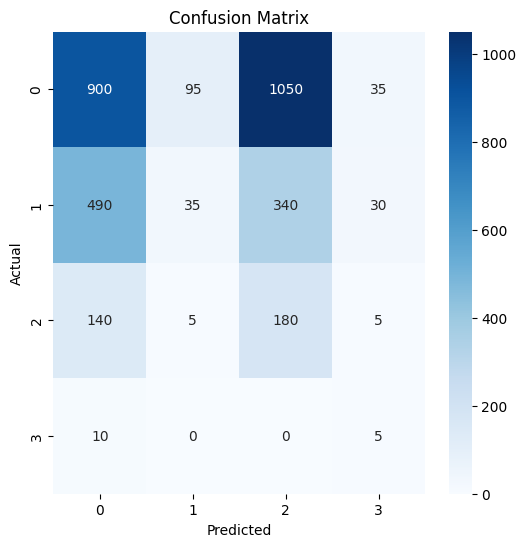

In [44]:
cm = confusion_matrix(y, y_pred_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()